# Hitparade auslesen und auswerten

Ein paar Pakete laden...

In [77]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time
from IPython.display import clear_output
from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_rows', 500) # Zeig mal ein bisschen mehr Zeilen bitte

## Jedes Datum, an dem neue Hitparaden veröffentlicht wurden, auslesen

In [3]:
daten = []

driver = webdriver.Chrome()
driver.get("https://hitparade.ch/charts/singles")

years = driver.find_element_by_name("year");
options = [x for x in years.find_elements_by_tag_name("option")] # Lese zuerst alle Jahre aus dem Dropdown
for y in options:
    
    select = Select(driver.find_element_by_name('year'))
    select.select_by_visible_text(y.get_attribute("value"))

    dates = driver.find_element_by_name("date");
    options = [x for x in dates.find_elements_by_tag_name("option")] # Dann lese alle Daten für ein Jahr
    for d in options:
            daten.append(d.get_attribute("value")) # ... und füge es zur Liste hinzu
            
driver.close()

In [4]:
# Für die interaktive Grafik brauche ich eine Liste mit allen Wochen, in denen eine Hitparade platziert wurde:
daten_form = []
for d in daten:
    daten_form.append(d[0:4]+"-"+d[4:6]+"-"+d[6:8])
print(daten_form)

['2019-02-24', '2019-02-17', '2019-02-10', '2019-02-03', '2019-01-27', '2019-01-20', '2019-01-13', '2019-01-06', '2018-12-30', '2018-12-23', '2018-12-16', '2018-12-09', '2018-12-02', '2018-11-25', '2018-11-18', '2018-11-11', '2018-11-04', '2018-10-28', '2018-10-21', '2018-10-14', '2018-10-07', '2018-09-30', '2018-09-23', '2018-09-16', '2018-09-09', '2018-09-02', '2018-08-26', '2018-08-19', '2018-08-12', '2018-08-05', '2018-07-29', '2018-07-22', '2018-07-15', '2018-07-08', '2018-07-01', '2018-06-24', '2018-06-17', '2018-06-10', '2018-06-03', '2018-05-27', '2018-05-20', '2018-05-13', '2018-05-06', '2018-04-29', '2018-04-22', '2018-04-15', '2018-04-08', '2018-04-01', '2018-03-25', '2018-03-18', '2018-03-11', '2018-03-04', '2018-02-25', '2018-02-18', '2018-02-11', '2018-02-04', '2018-01-28', '2018-01-21', '2018-01-14', '2018-01-07', '2017-12-31', '2017-12-24', '2017-12-17', '2017-12-10', '2017-12-03', '2017-11-26', '2017-11-19', '2017-11-12', '2017-11-05', '2017-10-29', '2017-10-22', '2017

## Für jedes Datum Hitparade auslesen

Jetzt gehen wir jede Woche durch und speichern uns alle Lieder ab 

In [6]:
# Leere Liste für alle Songs
swiss_songs = []

def createList(datestring):
    website = requests.get("https://hitparade.ch/charts/singles/"+datestring).text
    soup = BeautifulSoup(website, "html.parser")
    
    platzierung = 1
    for idx, titel in enumerate(soup.find_all('a', class_="navb")):
        # Finde Titel und Swiss-Kennzeichnung
        if titel.find('img'):
            swiss = True
        else:
            swiss = False
            
        tds = titel.find_all('b')
        song_artist = tds[0].text
        song_titel = titel.find("br").text
        
        swiss_songs.append({"artist":song_artist, "titel":song_titel, "swiss":swiss, "week": datestring, "platzierung": platzierung, "points": 101-platzierung})
        platzierung += 1
    
    
for date in daten: # Gehe jedes Datum durch und frage die Hitparade ab
    datum = datetime.datetime.strptime(date, "%Y%m%d").strftime("%d-%m-%Y")
    print("Scraping "+datum)
    createList(datum)
    clear_output() # Logge jeweils, bei welcher Woche du bist, aber lösche das danach wieder, sonst wird's zu lange



In [7]:
df_songs = pd.DataFrame(swiss_songs) # Mach daraus ein DataFrame

In [8]:
df_songs.head(4)

,artist,platzierung,points,swiss,titel,week
0,Ava Max,1,100,False,Sweet But Psycho,24-02-2019
1,Lady Gaga & Bradley Cooper,2,99,False,Shallow,24-02-2019
2,Ariana Grande,3,98,False,7 Rings,24-02-2019
3,Pedro Capó,4,97,False,Calma,24-02-2019


Speichere alle in eine Liste lokal ab

In [9]:
df_songs.to_csv("python_outputs/Titel.csv")

In [10]:
df_songs[df_songs["swiss"]].groupby("artist")["points"].sum().sort_values(ascending=False).to_csv("python_outputs/ErfolgreichsteArtisten.csv")

## Erste Auswertungen

In [11]:
# Zuerst eine eigene Spalte mit Jahr machen
df_songs['year'] = df_songs['week'].str.slice(start=-4)

In [12]:
# Der Datentyp soll eine Zahl sein
df_songs['year'] = pd.to_numeric(df_songs['year'])

In [13]:
# beziehungsweise ein Datum
df_songs['week'] = pd.to_datetime(df_songs['week'], format='%d-%m-%Y')

In [14]:
df_songs.head(2)

,artist,platzierung,points,swiss,titel,week,year
0,Ava Max,1,100,False,Sweet But Psycho,2019-02-24,2019
1,Lady Gaga & Bradley Cooper,2,99,False,Shallow,2019-02-24,2019


In [15]:
df_songs.dtypes # Prüfen, ob nun alle Datentypen stimmen

artist                 object
platzierung             int64
points                  int64
swiss                    bool
titel                  object
week           datetime64[ns]
year                    int64
dtype: object

In [17]:
len(df_songs) # Insgesamt sind rund 130'000 Songs im Dataframe

132110

## Daten für interaktive Grafik bereitstellen
Ablauf im D3.js-Skript:
1. Datenquelle einlesen
2. Filtern nach Interpret
3. x-Achse: 1969 - 2019
4. y-Achse: zwischen 1 und 101 (für Wochen ohne Platzierung 101 einfüllen)

In [18]:
# Damit das Datenfile auf der Seite nicht zu gross wird, begrenzen wir uns auf die wichtigsten Artisten
df_wichtige_artisten = df_songs.groupby('artist')['points'].sum().reset_index().sort_values('points')

In [19]:
df_wichtige_artisten

,artist,points
141,Alan Walker Feat. Gavin James,1
4576,Sido's Hands On Scooter feat. Kitty Kat & Tony D.,1
1126,"DJ Tomekk feat. Ice-T, Sandra Nasic, Trigga Th...",1
1314,Delerium feat. Sarah McLachlan,1
4971,The Chiki-Chaka Girls,1
711,Bu'neek,1
1998,Gucci Mane feat. Migos,1
3858,Patent Ochsner / Mimmo Locasciulli,1
4019,Post Malone Feat. Quavo,1
1056,DHT feat. Edmée,1


In [20]:
df_wichtige_artisten = (df_wichtige_artisten[df_wichtige_artisten['points']>=5000]) 
# Nur wer in seiner Karriere über 5000 Punkte geholt hat, schafft es in die Grafik
df_wichtige_artisten

,artist,points
3207,Marquess,5026
2178,Inner Circle,5035
535,Billy Idol,5036
1969,Gorillaz,5037
4196,Rick Astley,5055
592,Blümchen,5061
1573,Enigma,5098
3420,Mike Posner,5106
2566,Kate Ryan,5135
896,Chimène Badi,5140


In [21]:
# Array für Autocomplete in interaktiver Grafik
list(df_wichtige_artisten['artist'].sort_values())

['2 Unlimited',
 '50 Cent',
 '77 Bombay Street',
 'ABBA',
 'Ace Of Base',
 'Adele',
 'Aerosmith',
 'Akon',
 'Alan Walker',
 'Alanis Morissette',
 'Albert Hammond',
 'Alicia Keys',
 'Alizée',
 'All Saints',
 'Alphaville',
 'Alvaro Soler',
 'Amy Macdonald',
 'Amy Winehouse',
 'Anastacia',
 'Andreas Gabalier',
 'Aqua',
 'Ariana Grande',
 'Atomic Kitten',
 'Aventura',
 'Avicii',
 'Avril Lavigne',
 'Backstreet Boys',
 'Baschi',
 'Bastian Baker',
 'Bee Gees',
 'Beyoncé',
 'Billy Idol',
 'Birdy',
 'Bligg',
 'Blondie',
 'Blue',
 'Blümchen',
 'Bon Jovi',
 'Boney M.',
 'Boyzone',
 'Britney Spears',
 'Bruce Springsteen',
 'Bruno Mars',
 'Bryan Adams',
 'Calvin Harris',
 'Cappella',
 'Captain Hollywood Project',
 'Carly Rae Jepsen',
 'Cascada',
 'Charlie Puth',
 'Cher',
 'Chimène Badi',
 'Chris Brown',
 'Christina Aguilera',
 'Cliff Richard',
 'Coldplay',
 'Craig David',
 'Crazy Frog',
 'Creedence Clearwater Revival',
 'Cro',
 'Culcha Candela',
 'Culture Beat',
 'Cyndi Lauper',
 'Céline Dion',
 'D

In [29]:
# Liste mit den ersten Daten pro Jahr (für Beschriftung x-Achse interaktive Grafik)
list(df_songs.sort_values('week', ascending=True).groupby('year').first()['week'].dt.strftime('%Y-%m-%d'))

['1968-01-02',
 '1969-01-07',
 '1970-01-06',
 '1971-01-05',
 '1972-01-04',
 '1973-01-02',
 '1974-01-09',
 '1975-01-10',
 '1976-01-09',
 '1977-01-08',
 '1978-01-07',
 '1979-01-07',
 '1980-01-06',
 '1981-01-11',
 '1982-01-10',
 '1983-01-09',
 '1984-01-01',
 '1985-01-06',
 '1986-01-12',
 '1987-01-04',
 '1988-01-03',
 '1989-01-08',
 '1990-01-07',
 '1991-01-06',
 '1992-01-05',
 '1993-01-03',
 '1994-01-09',
 '1995-01-08',
 '1996-01-07',
 '1997-01-05',
 '1998-01-04',
 '1999-01-10',
 '2000-01-09',
 '2001-01-07',
 '2002-01-06',
 '2003-01-05',
 '2004-01-04',
 '2005-01-02',
 '2006-01-01',
 '2007-01-07',
 '2008-01-13',
 '2009-01-04',
 '2010-01-03',
 '2011-01-09',
 '2012-01-08',
 '2013-01-06',
 '2014-01-05',
 '2015-01-04',
 '2016-01-03',
 '2017-01-01',
 '2018-01-07',
 '2019-01-06']

In [23]:
# Jetzt kommt die Magie: Speichere für jede Woche, für jeden Interpreten, den höchstplatzierten Song in eine Liste
df_bestersong_nach_artist_und_woche = df_songs.loc[df_songs[df_songs['artist'].isin(list(df_wichtige_artisten['artist']))].groupby(['week', 'artist'])['platzierung'].idxmin()]
df_bestersong_nach_artist_und_woche = df_bestersong_nach_artist_und_woche.drop(['points'],axis=1)
df_bestersong_nach_artist_und_woche


,artist,platzierung,swiss,titel,week,year
132101,Bee Gees,2,False,Massachusetts,1968-01-02,1968
132103,The Beatles,4,False,"Hello, Good Bye",1968-01-02,1968
132091,Bee Gees,2,False,Massachusetts,1968-01-09,1968
132092,The Beatles,3,False,"Hello, Good Bye",1968-01-09,1968
132082,Bee Gees,3,False,World,1968-01-16,1968
132081,The Beatles,2,False,"Hello, Good Bye",1968-01-16,1968
132087,The Rolling Stones,8,False,She's A Rainbow,1968-01-16,1968
132071,Bee Gees,2,False,World,1968-01-23,1968
132073,The Beatles,4,False,"Hello, Good Bye",1968-01-23,1968
132074,The Rolling Stones,5,False,She's A Rainbow,1968-01-23,1968


In [24]:
# Als CSV speichern, damit man später ein JSON draus machen kann (benutze https://www.csvjson.com/)
df_bestersong_nach_artist_und_woche.to_csv('python_outputs/bestersong_nach_artist_und_woche.csv')

In [25]:
len(df_bestersong_nach_artist_und_woche) # 40'000 Zeilen, das gibt ca. ein 5MB grosses File, das ist ok

41803

In [26]:
# Schauen wir schnell, wie das zum Beispiel für ABBA aussieht
df_bestersong_nach_artist_und_woche[df_bestersong_nach_artist_und_woche['artist']=="ABBA"]

,artist,platzierung,swiss,titel,week,year
128915,ABBA,6,False,Waterloo,1974-04-17,1974
128900,ABBA,1,False,Waterloo,1974-04-24,1974
128890,ABBA,1,False,Waterloo,1974-05-01,1974
128880,ABBA,1,False,Waterloo,1974-05-08,1974
128870,ABBA,1,False,Waterloo,1974-05-15,1974
128860,ABBA,1,False,Waterloo,1974-05-22,1974
128850,ABBA,1,False,Waterloo,1974-05-29,1974
128840,ABBA,1,False,Waterloo,1974-06-05,1974
128830,ABBA,1,False,Waterloo,1974-06-12,1974
128820,ABBA,1,False,Waterloo,1974-06-19,1974


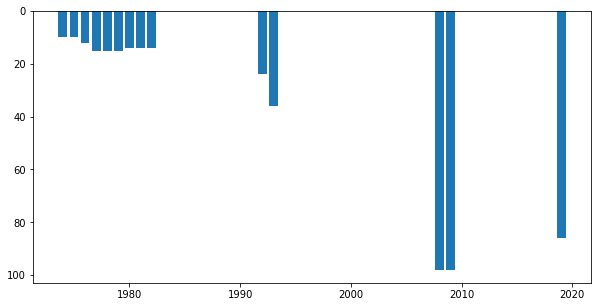

In [27]:
# So könnte die Grafik in etwa aussehen in D3, einfach die Balken aufsteigend von unten
plt.figure(figsize=(10,5))
plt.bar(df_bestersong_nach_artist_und_woche[df_bestersong_nach_artist_und_woche['artist']=="ABBA"]['year'], 
        df_bestersong_nach_artist_und_woche[df_bestersong_nach_artist_und_woche['artist']=="ABBA"]['platzierung'])
plt.gca().invert_yaxis()


In [28]:
# Prüfe nochmals mit dem originalen Dataframe schnell, ob das stimmen könnte
df_songs[df_songs['artist']=="ABBA"].groupby(['week', 'titel'])['platzierung'].min()

week        titel                                      
1974-04-17  Waterloo                                        6
1974-04-24  Waterloo                                        1
1974-05-01  Waterloo                                        1
1974-05-08  Waterloo                                        1
1974-05-15  Waterloo                                        1
1974-05-22  Waterloo                                        1
1974-05-29  Waterloo                                        1
1974-06-05  Waterloo                                        1
1974-06-12  Waterloo                                        1
1974-06-19  Waterloo                                        1
1974-06-26  Waterloo                                        2
1974-07-03  Waterloo                                        2
1974-07-10  Waterloo                                        3
1974-07-17  Waterloo                                        3
1974-07-24  Waterloo                                        5
1974-07-31  Wa

## Weitere Auswertungen
Alles, was für meine Geschichte sonst noch relevant sein könnte

In [30]:
# Welche Künstler haben denn am meisten Punkte geholt?
df_songs.groupby('artist')['points'].sum().reset_index().sort_values("points", ascending=False).head(3)


,artist,points
3083,Madonna,62997
4209,Rihanna,43282
1487,Ed Sheeran,40341


In [31]:
# Ewige Bestenliste nach Songs (nach Punkten)
df_songs.groupby(['artist', 'titel'])['points'].sum().reset_index().sort_values("points", ascending=False).head(30)


,artist,titel,points
2411,DJ Ötzi & Nik P.,Ein Stern (... der deinen Namen trägt),8109
3140,Ed Sheeran,Shape Of You,7666
6198,Luis Fonsi feat. Daddy Yankee,Despacito,6937
2279,DJ Antoine feat. The Beat Shakers,"""Ma chérie""",6745
227,Adele,Rolling In The Deep,6588
4983,John Legend,All Of Me,6547
3138,Ed Sheeran,Perfect,6417
496,Amy Macdonald,This Is The Life,6125
10320,The Black Eyed Peas,I Gotta Feeling,6085
9454,Shakira feat. Freshlyground,Waka Waka (This Time For Africa),6004


Alle einzelnen Songs herausfinden:

In [32]:
# Welcher Song war am meisten Wochen in den Charts vertreten?
df_songs.groupby(['artist', 'titel']).size().reset_index(name="totalwochen").sort_values('totalwochen', ascending=False).head(20)


,artist,titel,totalwochen
2411,DJ Ötzi & Nik P.,Ein Stern (... der deinen Namen trägt),118
3140,Ed Sheeran,Shape Of You,111
9751,Snow Patrol,Chasing Cars,106
922,Baschi,Bring en hei,100
6360,Madonna,Hung Up,99
2279,DJ Antoine feat. The Beat Shakers,"""Ma chérie""",99
4687,James Blunt,You're Beautiful,97
4983,John Legend,All Of Me,97
231,Adele,Someone Like You,95
496,Amy Macdonald,This Is The Life,94


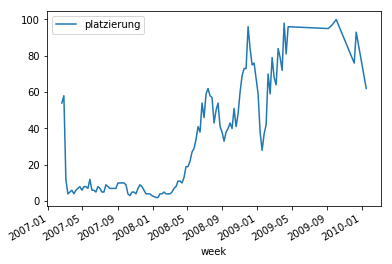

In [33]:
# So hat sich die Platzierung von DJ Ötzi entwickelt
df_songs[(df_songs['artist']=="DJ Ötzi & Nik P.")&(df_songs['titel']=="Ein Stern (... der deinen Namen trägt)")].plot.line(x='week', y='platzierung')

In [34]:
# Wer war am häufigsten auf Platz 1?
df_songs[df_songs['platzierung'] == 1].groupby(['artist', 'titel']).size().reset_index(name='anzahl').sort_values('anzahl', ascending=False).head(10)

,artist,titel,anzahl
274,Lo & Leduc,079,21
150,Ed Sheeran,Perfect,20
285,Luis Fonsi feat. Daddy Yankee,Despacito,20
270,Lilly Wood & The Prick and Robin Schulz,Prayer In C (Robin Schulz Remix),17
457,Shakira,Whenever Wherever,17
79,Bryan Adams,(Everything I Do) I Do It For You,16
110,Céline Dion,My Heart Will Go On,15
246,Kaoma,Lambada,14
73,Boney M.,Rivers Of Babylon,14
472,Snap!,Rhythm Is A Dancer,14


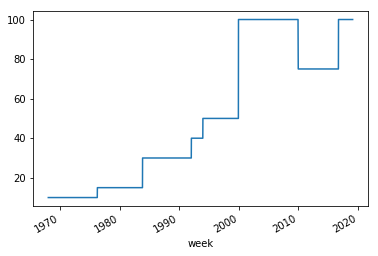

In [38]:
# Wie viele Titel lang war die Hitparade überhaupt in jedem Jahr?
df_songs.groupby('week')['year'].count().plot()

## These: Brauchte man früher mehr «Anläufe» für einen Nummer 1 Hit als heute?

In [39]:
# Schaue mal für alle Nummer 1 Hits, wie lange sie auf Platz 1 waren
df_songs[df_songs['platzierung']==1].groupby(['artist', 'titel']).size().reset_index(name='anzahlwochen')

,artist,titel,anzahlwochen
0,2 Unlimited,No Limit,5
1,4 Non Blondes,What's Up?,14
2,4 The Cause,Stand By Me,4
3,50 Cent,In Da Club,3
4,50 Cent feat. Olivia,Candy Shop,5
5,ABBA,Chiquitita,2
6,ABBA,Fernando,11
7,ABBA,Gimme! Gimme! Gimme! (A Man After Midnight),1
8,ABBA,"I Do, I Do, I Do, I Do, I Do",5
9,ABBA,I Have A Dream,2


In [40]:
# Suche für jeden Künstler seinen ersten Nummer 1 Hit
df_erste_nummer1 = df_songs[df_songs['platzierung']==1].groupby(['artist']).last().reset_index().sort_values('week')
df_erste_nummer1

,artist,platzierung,points,swiss,titel,week,year
353,Roland W.,1,100,False,Monja,1968-01-02,1968
196,John Fred & His Playboy Band,1,100,False,Judy In Disguise (With Glasses),1968-02-06,1968
42,Bee Gees,1,100,False,Words,1968-03-12,1968
423,The Beatles,1,100,False,Lady Madonna,1968-03-26,1968
443,Tom Jones,1,100,False,Delilah,1968-04-23,1968
136,Engelbert,1,100,False,A Man Without Love,1968-06-18,1968
224,Les Sauterelles,1,100,True,Heavenly Club,1968-07-30,1968
258,Mary Hopkin,1,100,False,Those Were The Days,1968-10-22,1968
194,Joe Cocker,1,100,False,With A Little Help From My Friends,1968-12-03,1968
437,The Tremeloes,1,100,False,My Little Lady,1968-12-10,1968


In [41]:
# Wieviele Artisten haben es überhaupt schon auf die Nummer 1 geschafft?
len(df_erste_nummer1)

475

In [42]:
# Kleiner Test, ob zum Beispiel bei Ava Max der richtige Wert herauskommt
df_songs[df_songs['artist']=="Ava Max"].sort_values('week')

,artist,platzierung,points,swiss,titel,week,year
1643,Ava Max,44,57,False,Sweet But Psycho,2018-11-04,2018
1514,Ava Max,15,86,False,Sweet But Psycho,2018-11-11,2018
1401,Ava Max,2,99,False,Sweet But Psycho,2018-11-18,2018
1301,Ava Max,2,99,False,Sweet But Psycho,2018-11-25,2018
1200,Ava Max,1,100,False,Sweet But Psycho,2018-12-02,2018
1100,Ava Max,1,100,False,Sweet But Psycho,2018-12-09,2018
1000,Ava Max,1,100,False,Sweet But Psycho,2018-12-16,2018
900,Ava Max,1,100,False,Sweet But Psycho,2018-12-23,2018
803,Ava Max,4,97,False,Sweet But Psycho,2018-12-30,2018
700,Ava Max,1,100,False,Sweet But Psycho,2019-01-06,2019


In [43]:
# Jetzt berechnen wir, viele Platzierungen in den Wochencharts unsere Künstler vor ihrem 1. Nummer-1-Hit hatten
anzahl_vorsongs = []
for index, row in df_erste_nummer1.iterrows():
    # Wieviele Punkte überhaupt in Karriere gesammelt?
    karrierepunkte = df_songs[df_songs['artist']==row['artist']]['points'].sum()
    # Speichere im Format [Künstler, Platzierungen vor Nr1, Zeitpunkt Nr1, Jahr Nr1, Punkte in ganzer Karriere, Titel Nr1, Schweiz]
    anzahl_vorsongs.append([row['artist'],len(df_songs[(df_songs['artist'] == row['artist']) & (df_songs['week']<row['week'])]),row['week'],row['year'],karrierepunkte,row['titel'],row['swiss']])
    
    

In [46]:
# So sieht dann ein Eintrag aus
anzahl_vorsongs[80]

['Plastic Bertrand',
 3,
 Timestamp('1978-09-02 00:00:00'),
 1978,
 1038,
 'Ça plane pour moi',
 False]

In [47]:
# Aus dieser Liste machen wir jetzt ein Dataframe
df_vorsongs = pd.DataFrame(anzahl_vorsongs)
df_vorsongs.columns = ['artist', 'vorsongs', 'week_of_number1','year_of_number1','karrierepunkte','titel','swiss']
df_vorsongs[df_vorsongs['vorsongs']==0].sort_values(['vorsongs', 'week_of_number1']).to_csv('python_outputs/Senkrechtstarter.csv')

Für eine Übersichtsgrafik mit Senkrechtstartern in der Geschichte der Hitparade lesen wir die erfolgreichsten Künstler heraus (alle über 13500 Karrierenpunkten). Ausserdem lassen wir alle vor 1980 weg, die Hitparade anfangs noch kürzer war und die Daten daher weniger aussagekräftig waren.

In [51]:
df_topartists = df_vorsongs[(df_vorsongs['week_of_number1']>'1980-01-01')&(df_vorsongs['karrierepunkte']>13500) | (df_vorsongs['artist']=="Ava Max")].sort_values('vorsongs',ascending=True)[['artist', 'vorsongs','karrierepunkte','swiss','week_of_number1','titel']]
df_topartists


,artist,vorsongs,karrierepunkte,swiss,week_of_number1,titel
304,Shakira,1,17634,False,2002-02-03,Whenever Wherever
392,Adele,1,25265,False,2011-02-06,Rolling In The Deep
366,Katy Perry,1,20624,False,2008-08-24,I Kissed A Girl
152,George Michael,2,17824,False,1984-09-30,Careless Whisper
318,The Black Eyed Peas,2,32448,False,2003-09-21,Where Is The Love?
281,Britney Spears,2,33680,False,1999-03-14,...Baby One More Time
189,Kylie Minogue,4,21491,False,1988-04-17,I Should Be So Lucky
470,Ava Max,4,1631,False,2018-12-02,Sweet But Psycho
107,Phil Collins,5,18172,False,1981-05-10,In The Air Tonight
199,Roxette,7,25958,False,1989-05-28,The Look


In [52]:
# Für die Balkengrafik haben wir verschiedene Farben. Hellgrau für Schweizer Künstler, Dunkelgrau für die Restlichen. 
# Ava Max heben wir mit Pink hervor, sie liegt an 8. Stelle. 

colors = []
for e in list(df_topartists['swiss']):
    if(e):
        colors.append("#6B6B6B")
    else:
        colors.append("#282828")
        
colors[7] = "#F40F97" # Highlights Ava Max

/Users/leasenn/.virtualenvs/erstesVE/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


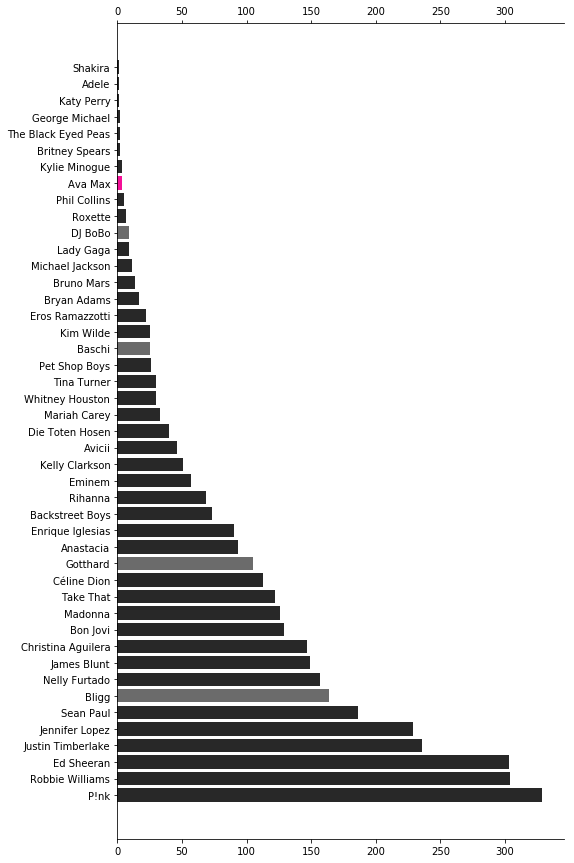

In [53]:
plt.figure(figsize=(8,15))
plt.barh(df_topartists['artist'], df_topartists['vorsongs'], color=colors)
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
plt.gca().invert_yaxis()
ax = plt.subplot(111)
ax.spines['right'].set_color('white')
plt.savefig("python_outputs/top_artists_vorsongs.png", dpi=300, bbox_inches='tight')

Jetzt wollen wir mal die zeitliche Verteilung anschauen: Ist das Senkrechtstarten ein neues Phänomen? Schauen wir uns alle Künstler an, die es in einem Jahr zum ersten Mal in ihrer Karriere auf Platz 1 geschafft haben. Wir nehmen alle Vorwochen-Anzahlen von ihnen und berechnen für jedes Jahr den Median.

In [54]:
df_vorsongs.groupby('year_of_number1').median().reset_index().tail(10)

,year_of_number1,vorsongs,karrierepunkte,swiss
42,2010,5.0,2972.5,False
43,2011,5.0,4058.0,False
44,2012,5.5,3578.0,False
45,2013,5.5,4001.0,False
46,2014,5.0,4769.0,False
47,2015,8.0,4573.0,False
48,2016,4.0,3101.0,False
49,2017,13.0,6937.0,False
50,2018,4.0,2860.0,False
51,2019,27.5,2084.5,False


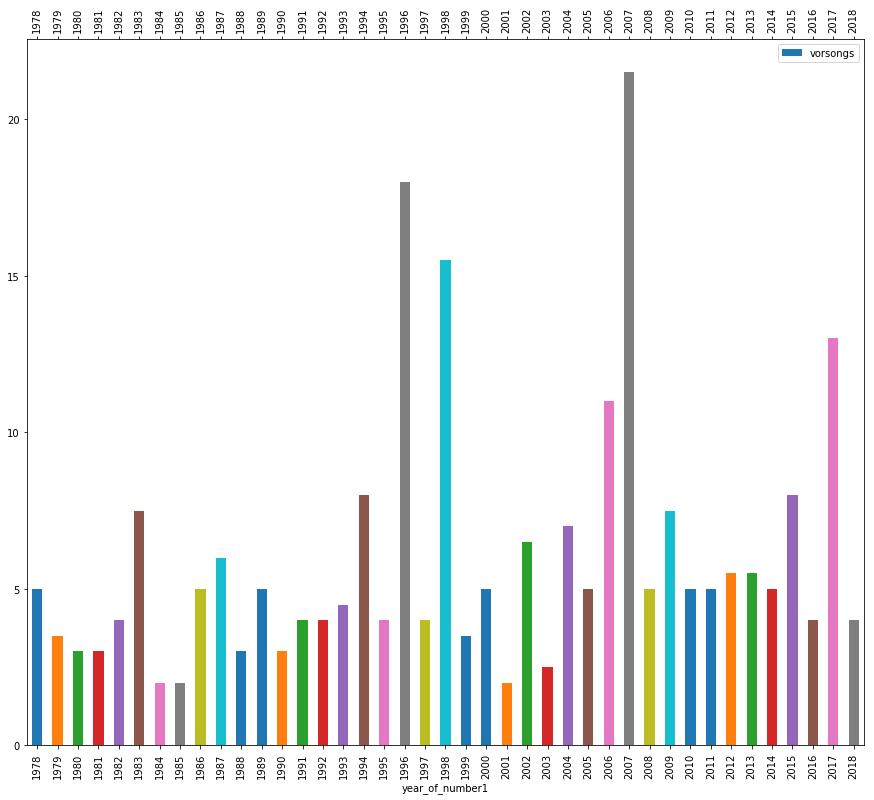

In [55]:
df_vorsongs[(df_vorsongs['week_of_number1']>= '1978-01-01')&(df_vorsongs['week_of_number1']<= '2019-01-01')].groupby('year_of_number1').median().reset_index().plot(x='year_of_number1',y='vorsongs', kind="bar",figsize=(15,13))


Betrachtet man den Median über ein ganzes Jahr, zeichnet sich also keine allzu deutliche Veränderung über die Jahre an. Schauen wir uns die absoluten Zahlen an.

Definieren wir Senkrechtstartet mal so: Vor ihrem ersten Nummer-1-Hit waren sie 5 oder weniger Wochen in den Charts vertreten. Mal schauen, wie viele solche Senkrechtstarter es gab pro Jahr (in absoluten Zahlen).

In [56]:
df_vorsongs[(df_vorsongs['week_of_number1']>= '1975-01-01')&(df_vorsongs['week_of_number1']< '2019-01-01')&(df_vorsongs['vorsongs']<= 5)].sort_values('week_of_number1', ascending=False)

,artist,vorsongs,week_of_number1,year_of_number1,karrierepunkte,titel,swiss
470,Ava Max,4,2018-12-02,2018,1631,Sweet But Psycho,False
469,Lady Gaga & Bradley Cooper,1,2018-10-14,2018,2860,Shallow,False
468,Dynoro & Gigi D'Agostino,5,2018-08-19,2018,3062,In My Mind,False
467,Capital Bra feat. Juju,0,2018-08-12,2018,869,Melodien,False
465,Zayn feat. Sia,3,2017-10-08,2017,2688,Dusk Till Dawn,False
462,Clean Bandit feat. Sean Paul & Anne-Marie,5,2016-12-04,2016,3402,Rockabye,False
460,Sia feat. Kendrick Lamar,1,2016-09-18,2016,2293,The Greatest,False
459,DJ Snake feat. Justin Bieber,4,2016-09-11,2016,3101,Let Me Love You,False
458,Major Lazer feat. Justin Bieber & MØ,1,2016-08-07,2016,2294,Cold Water,False
456,David Guetta feat. Zara Larsson,4,2016-06-19,2016,1666,This One's For You,False


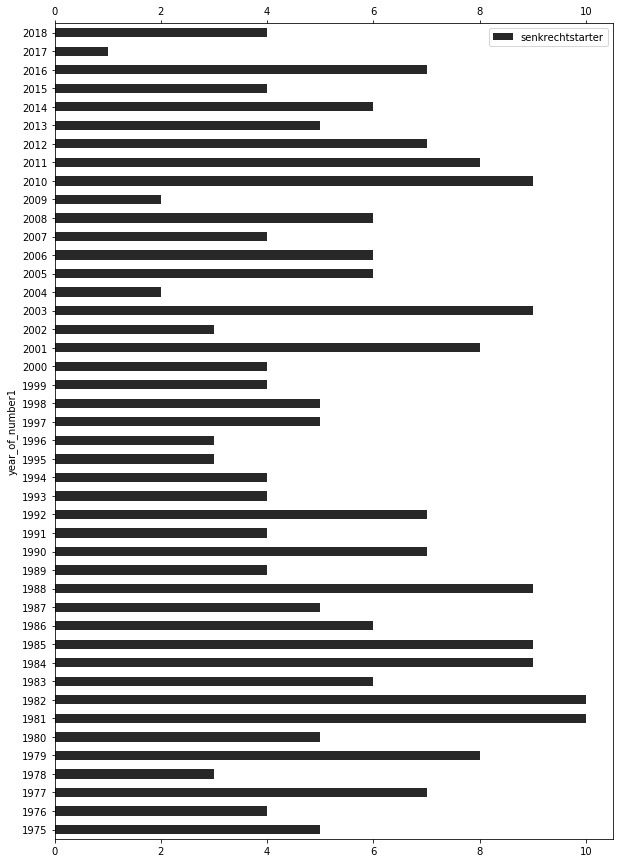

In [57]:
# Eine Balkengrafik scheint mir zu langweilig. Ich werde das später in Illustrator mit Menschenicons zeichnen, 
# aber plotten wir das mal vorläufig so. 
df_vorsongs[(df_vorsongs['week_of_number1']>= '1975-01-01')&(df_vorsongs['week_of_number1']< '2019-01-01')&(df_vorsongs['vorsongs']<= 5)].groupby('year_of_number1').size().reset_index(name="senkrechtstarter").plot(x='year_of_number1',y='senkrechtstarter',kind="barh",color="#282828",figsize=(10,15))



## Waren die erfolgreichen Musiker alle Senkrechtstarter?

Madonna, Rihanna & Co hielten sich über Jahre in den Schweizer Charts. Waren sie Senkrechtstarter?

In [58]:
# Für jedes Jahr berechnen wieviele Wochen die Songs in den Top 100 hatten
df_swiss_timeline = pd.DataFrame(df_songs.groupby(['artist', 'year']).size()).reset_index()

In [59]:
df_swiss_timeline.columns = ['artist', 'year', 'anzahl']

In [60]:
df_swiss_timeline.head(10)

,artist,year,anzahl
0,'N Sync,1996,7
1,'N Sync,1997,39
2,'N Sync,1998,14
3,'N Sync feat. Nelly,2002,12
4,*N Sync,2000,56
5,*N Sync,2001,19
6,*N Sync,2018,1
7,1 City 1 Song,2013,1
8,1 Giant Leap feat. Maxi Jazz & Robbie Williams,2002,6
9,10cc,1975,9


In [62]:
# Berechne schnell, wie viele Platzierungen dieser Künstler total hatte
total = df_swiss_timeline.groupby('artist')['anzahl'].sum().reset_index(name='totalplatzierungen')
total = (total[total['totalplatzierungen']>200]) #... nur wenn er über 200 hatte, nehme ihn in unsere Artistenliste auf
artistlist = list(total['artist'])

In [64]:
df_swiss_timeline = df_swiss_timeline[df_swiss_timeline['artist'].isin(artistlist)] 
# Wenn er Künstler in der Liste ist, dann arbeite weiter mit seinen Daten > unwichtige Künstler müssen weg
df_swiss_timeline.head(3)

,artist,year,anzahl
129,ABBA,1974,31
130,ABBA,1975,36
131,ABBA,1976,58


In [65]:
df_swiss_timeline_stats = pd.DataFrame(df_swiss_timeline.groupby('artist')['anzahl'].sum()).sort_values('anzahl', ascending=True).reset_index()
# Speichere als Statistik, wieviele Platzierungen ein Künstler überhaupt hatte 
# (das kommt dann in der Legende direkt neben den Namen)

In [66]:
df_swiss_timeline_stats = df_swiss_timeline_stats.reset_index()

In [67]:
df_swiss_timeline_stats.head(2)

,index,artist,anzahl
0,0,Amy Macdonald,203
1,1,Red Hot Chili Peppers,205


In [68]:
# Spalten umbenennen, die Artist_id brauchen wir später, um sie im Scatterplot auf eine Reihe zu zeichnen
df_swiss_timeline_stats.columns = ['artist_id', 'artist', 'anzahl_karriere']

In [69]:
df_swiss_timeline_stats.sort_values('anzahl_karriere', ascending=False).head(15)

,artist_id,artist,anzahl_karriere
70,70,Madonna,909
69,69,Rihanna,674
68,68,P!nk,657
67,67,Ed Sheeran,605
66,66,Britney Spears,543
65,65,Michael Jackson,541
64,64,The Black Eyed Peas,481
63,63,Coldplay,466
62,62,Robbie Williams,453
61,61,DJ BoBo,443


In [70]:
# In unserer Geschichte geht es um die erste Nummer-1-Platzierung. Also wollen wir diesen Moment auch in der
# Grafik entsprechend markieren. Dazu können wir das df von oben nochmals brauchen...
df_erste_nummer1.head(3)

,artist,platzierung,points,swiss,titel,week,year
353,Roland W.,1,100,False,Monja,1968-01-02,1968
196,John Fred & His Playboy Band,1,100,False,Judy In Disguise (With Glasses),1968-02-06,1968
42,Bee Gees,1,100,False,Words,1968-03-12,1968


In [71]:
# Jetzt mergen wir die einzelnen Platzierungen mit den Statistiken
df_swiss_timeline_merged = pd.merge(df_swiss_timeline, df_swiss_timeline_stats, how='left', on='artist')
df_swiss_timeline_merged.sort_values(['artist_id', 'year']).tail(15)

,artist,year,anzahl,artist_id,anzahl_karriere
557,Madonna,1999,35,70,909
558,Madonna,2000,54,70,909
559,Madonna,2001,45,70,909
560,Madonna,2002,7,70,909
561,Madonna,2003,39,70,909
562,Madonna,2004,22,70,909
563,Madonna,2005,6,70,909
564,Madonna,2006,104,70,909
565,Madonna,2007,50,70,909
566,Madonna,2008,38,70,909


In [73]:
# Und hier nehmen wir das Jahr der ersten Nummer 1 Platzierung dazu...
df_erste_nummer1[['artist','year']].head(1)

,artist,year
353,Roland W.,1968


In [74]:
# Also nochmals mergen
df_swiss_timeline_merged_extended = pd.merge(df_swiss_timeline_merged, df_erste_nummer1[['artist','year']], how="left", on="artist")


In [75]:
# Räumen wir ein bisschen auf, damit das logischer benannt ist
df_swiss_timeline_merged_extended = df_swiss_timeline_merged_extended.rename(columns = {'year_x':"year", 'year_y':'year_of_first_number_1'})
df_swiss_timeline_merged_extended


,artist,year,anzahl,artist_id,anzahl_karriere,year_of_first_number_1
0,ABBA,1974,31,44,319,1974.0
1,ABBA,1975,36,44,319,1974.0
2,ABBA,1976,58,44,319,1974.0
3,ABBA,1977,34,44,319,1974.0
4,ABBA,1978,39,44,319,1974.0
5,ABBA,1979,40,44,319,1974.0
6,ABBA,1980,32,44,319,1974.0
7,ABBA,1981,8,44,319,1974.0
8,ABBA,1982,13,44,319,1974.0
9,ABBA,1992,11,44,319,1974.0


In [76]:
# In der Grafik wollen wir dann natürlich den Namen sehen, nicht die artist_id, also bereiten wir folgende Liste vor:
yticklable = df_swiss_timeline_stats['artist'].tolist()
yticklable

['Amy Macdonald',
 'Red Hot Chili Peppers',
 'Tiziano Ferro',
 'The Rolling Stones',
 "Destiny's Child",
 'Jason Derulo',
 'Leona Lewis',
 'Amy Winehouse',
 'Janet Jackson',
 'Take That',
 'Avril Lavigne',
 'Westlife',
 'Queen',
 'Xavier Naidoo',
 'Bee Gees',
 'Die Toten Hosen',
 'Sean Paul',
 'Phil Collins',
 'Bryan Adams',
 'Maroon 5',
 'George Michael',
 'Enrique Iglesias',
 'Elton John',
 'Lenny Kravitz',
 'Gotthard',
 'Nickelback',
 'Baschi',
 'Scooter',
 'Kelly Clarkson',
 'Christina Aguilera',
 'Mika',
 'Shakira',
 'Sugababes',
 'Pet Shop Boys',
 'Whitney Houston',
 'Beyoncé',
 'Anastacia',
 'Bruno Mars',
 'U2',
 'Bligg',
 'Justin Timberlake',
 'Eros Ramazzotti',
 'Avicii',
 'Jennifer Lopez',
 'ABBA',
 'Katy Perry',
 'Roxette',
 'OneRepublic',
 'Kylie Minogue',
 'Depeche Mode',
 'Nelly Furtado',
 'Linkin Park',
 'Eminem',
 'Mariah Carey',
 'Backstreet Boys',
 'James Blunt',
 'Céline Dion',
 'Lady Gaga',
 'Imagine Dragons',
 'Adele',
 'Bon Jovi',
 'DJ BoBo',
 'Robbie Williams',
 

In [78]:
# Sortieren wir mal nach Künstlern, jeweils chronologisch
df_swiss_timeline_merged_extended.sort_values(['artist_id', 'year']).tail(150)

,artist,year,anzahl,artist_id,anzahl_karriere,year_of_first_number_1
236,DJ BoBo,2007,22,61,443,1993.0
237,DJ BoBo,2008,13,61,443,1993.0
238,DJ BoBo,2010,7,61,443,1993.0
239,DJ BoBo,2011,1,61,443,1993.0
758,Robbie Williams,1996,10,62,453,2006.0
759,Robbie Williams,1997,3,62,453,2006.0
760,Robbie Williams,1998,30,62,453,2006.0
761,Robbie Williams,1999,4,62,453,2006.0
762,Robbie Williams,2000,40,62,453,2006.0
763,Robbie Williams,2001,60,62,453,2006.0


In [79]:
# Schauen wir uns schnell DJ BoBo an, könnte das passen?
df_swiss_timeline_merged_extended[df_swiss_timeline_merged_extended['artist']=="DJ BoBo"]

,artist,year,anzahl,artist_id,anzahl_karriere,year_of_first_number_1
223,DJ BoBo,1993,66,61,443,1993.0
224,DJ BoBo,1994,66,61,443,1993.0
225,DJ BoBo,1995,52,61,443,1993.0
226,DJ BoBo,1996,37,61,443,1993.0
227,DJ BoBo,1997,28,61,443,1993.0
228,DJ BoBo,1998,32,61,443,1993.0
229,DJ BoBo,1999,12,61,443,1993.0
230,DJ BoBo,2000,4,61,443,1993.0
231,DJ BoBo,2001,14,61,443,1993.0
232,DJ BoBo,2002,13,61,443,1993.0


In [80]:
# Einige Künstlernamen sind soooo lange, da hat meine Grafik gar keinen Platz mehr! 
# Schneiden wir besser schnell etwas ab, wenn's zu lange wird...
shortnames = []
for index, row in df_swiss_timeline_merged_extended.iterrows():
    if len(row['artist']) > 30:
        shortnames.append(row['artist'][:30]+"... ("+str(row['anzahl_karriere'])+")")
    else:
        shortnames.append(row['artist']+" ("+str(row['anzahl_karriere'])+")")
    
len(shortnames)

955

In [887]:
df_swiss_timeline_merged_extended.head(10)

,artist,year,anzahl,artist_id,anzahl_karriere,year_of_first_number_1
0,ABBA,1974,31,44,319,1974.0
1,ABBA,1975,36,44,319,1974.0
2,ABBA,1976,58,44,319,1974.0
3,ABBA,1977,34,44,319,1974.0
4,ABBA,1978,39,44,319,1974.0
5,ABBA,1979,40,44,319,1974.0
6,ABBA,1980,32,44,319,1974.0
7,ABBA,1981,8,44,319,1974.0
8,ABBA,1982,13,44,319,1974.0
9,ABBA,1992,11,44,319,1974.0


In [82]:
# Sortieren wir also nach Künstler, dann jeweils chronologisch
df_swiss_timeline_merged_extended = df_swiss_timeline_merged_extended.sort_values(['artist_id', 'year'])

In [83]:
# Bereiten wir die schwarzen Rahmen vor für das Jahr, wo der erste Nr1-Hit gelandet wurde
first_number_1 = list(df_swiss_timeline_merged_extended['year']==df_swiss_timeline_merged_extended['year_of_first_number_1'])
color_first_number_1 = []
for f in first_number_1:
    if f:
        color_first_number_1.append("black")
    else:
        color_first_number_1.append("none")
    

In [84]:
# Für die Farbskala brauchen wir noch das hier:
import matplotlib.colors

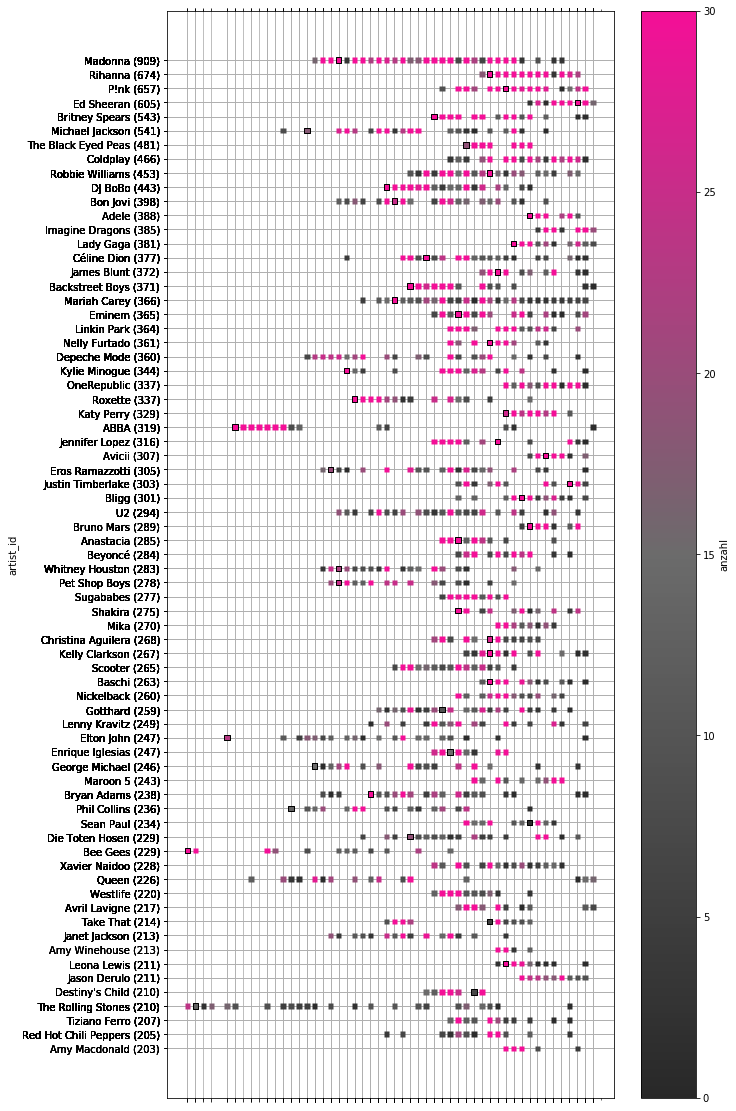

In [85]:
norm=plt.Normalize(0,30,60)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#282828","#6B6B6B","#F40F97"]) # Mein eigener Farbverlauf

# Ein Scatterplot mit Quadraten statt Punkten
ax = df_swiss_timeline_merged_extended.sort_values(['artist_id', 'year']).plot.scatter(x='year', y='artist_id', marker='s',edgecolors=color_first_number_1, s=30, c="anzahl", cmap=cmap, norm=norm, figsize=(10,20))
ax.set_xticks(df_swiss_timeline_merged_extended['year'])
ax.set_xticklabels(df_swiss_timeline_merged_extended['year'])

ax.set_yticks(df_swiss_timeline_merged['artist_id'])
ax.set_yticklabels(shortnames)

plt.grid()
ax.set_axisbelow(True)
plt.savefig("python_outputs/timeline.png", dpi=300, bbox_inches='tight') # dpi=300 hilft, dass die Auflösung gut genug ist
